In [31]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [32]:
# Load processed data (ensure these exist and include 'date', 'tic', 'close', etc.)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [33]:
# CELL 1: Imports & metrics helper

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Expect these to already exist in your session:
# - trade: DataFrame (long format) with columns incl. 'date','tic','close', indicators, etc.
# - INDICATORS: list of indicator column names
if "RESULTS_DIR" not in globals():
    RESULTS_DIR = os.path.join(os.getcwd(), "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# FinRL / SB3 imports
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

def compute_financial_metrics(values, steps_per_year=252):
    v = np.asarray(values, dtype=float)
    assert v.ndim == 1 and len(v) > 1, "values must be 1D series with len > 1"
    r = np.diff(v) / v[:-1]
    mean_r = np.mean(r)
    std_r  = np.std(r, ddof=1) if len(r) > 1 else 0.0

    n = len(v) - 1
    ann_return = (v[-1] / v[0])**(steps_per_year / max(n, 1)) - 1
    ann_vol    = (std_r * np.sqrt(steps_per_year)) if std_r > 0 else 0.0
    sharpe     = (mean_r / std_r * np.sqrt(steps_per_year)) if std_r > 0 else 0.0

    peak = np.maximum.accumulate(v)
    dd = (v - peak) / peak
    max_dd = dd.min()

    calmar = (ann_return / abs(max_dd)) if max_dd < 0 else np.inf

    return {
        "Annual Return": round(ann_return * 100.0, 2),
        "Annual Volatility": round(ann_vol * 100.0, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Calmar Ratio": round(calmar, 2 if np.isfinite(calmar) else 0),
        "Max Drawdown": f"{round(max_dd * 100.0, 1)}%",
    }


In [34]:
# CELL 2: Config — per-algorithm, per-method folders + seeds

LOOP_COUNT = 3  # you asked for 3

# Choose the algos you have models for (add/remove as needed)
ALGO_LIST = ["PPO", "DDPG", "TD3", "SAC"]  # e.g., you can add "A2C"

# Map: method -> { ALGO -> folder_path }
# Put the FOLDER that contains seed files like: ALGO_5k_0.zip, ALGO_5k_1.zip, ALGO_5k_2.zip
# CELL: corrected METHOD_PATHS (edit absolute paths!)
METHOD_PATHS = {
    "Baseline": {
        "PPO":  "tuning_models\\Baseline\\PPO",
        "DDPG": "tuning_models\\Baseline\\DDGP",
        "TD3":  "tuning_models\\Baseline\\TD3",
        "SAC":  "tuning_models\\Baseline\\SAC",
    },
    "Meta-gradient tuning": {
        "PPO":  "tuning_models\\Meta-gradient\\PPO",
        "DDPG": "tuning_models\\Meta-gradient\\DDGP",  # <-- fixed
        "TD3":  "tuning_models\\Meta-gradient\\TD3",
        "SAC":  "tuning_models\\Meta-gradient\\SAC",
    },
    "Multi-objective Optuna": {
        "PPO":  "tuning_models\\Multi-objective Optuna\\PPO",
        "DDPG": "tuning_models\\Multi-objective Optuna\\DDGP",  # <-- fixed
        "TD3":  "tuning_models\\Multi-objective Optuna\\TD3",
        "SAC":  "tuning_models\\Multi-objective Optuna\\SAC",
    },
}


# Where to save results
TUNING_RESULTS_DIR = os.path.join(RESULTS_DIR, "two_tunings_eval_per_algo_paths")
os.makedirs(TUNING_RESULTS_DIR, exist_ok=True)

# quick sanity on path types
for method, m in METHOD_PATHS.items():
    for algo, p in m.items():
        if algo in ALGO_LIST and not isinstance(p, (str, os.PathLike)):
            raise TypeError(f"{method}/{algo} path must be a string; got {type(p).__name__}")


In [35]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension

In [36]:
# CELL 3: Helper functions (load model, evaluate, find model file, safe name)

def load_model_by_algo(model_path, algo):
    algo = algo.upper()
    if   algo == "PPO":
        from stable_baselines3 import PPO;  return PPO.load(model_path)
    elif algo == "A2C":
        from stable_baselines3 import A2C;  return A2C.load(model_path)
    elif algo == "TD3":
        from stable_baselines3 import TD3;  return TD3.load(model_path)
    elif algo == "SAC":
        from stable_baselines3 import SAC;  return SAC.load(model_path)
    elif algo == "DDPG":
        from stable_baselines3 import DDPG; return DDPG.load(model_path)
    else:
        raise ValueError(f"Unsupported algo: {algo}")

def evaluate_one_model(model_path, trade_df):
    # infer algo from filename prefix (e.g., 'PPO_5k_0.zip' -> 'PPO')
    algo = os.path.basename(model_path).split('_')[0].upper()
    buy_cost_list = sell_cost_list = [0.001] * stock_dimension
    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1000000,
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_list,
        "sell_cost_pct": sell_cost_list,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }
    e_trade_gym = StockTradingEnv(
        df=trade_df, turbulence_threshold=55, risk_indicator_col="vix", **env_kwargs
    )
    model = load_model_by_algo(model_path, algo)
    df_account_value, _ = DRLAgent.DRL_prediction(model=model, environment=e_trade_gym)
    return df_account_value["account_value"].values  # 1D equity curve

def find_model_file(folder, algo, i):
    # Standard pattern: ALGO_5k_i.zip
    cand = os.path.join(folder, f"{algo}_5k_{i}.zip")
    if os.path.isfile(cand):
        return cand
    # Flexible matching if you used other names (seed, etc.)
    globs = [
        os.path.join(folder, f"*{algo}*{i}*.zip"),
        os.path.join(folder, f"{algo}*{i}.zip"),
        os.path.join(folder, f"{algo}_*{i}*.zip"),
    ]
    matches = []
    for g in globs:
        matches += glob.glob(g)
    return sorted(matches)[0] if matches else None

def safe_name(s: str) -> str:
    """Make a string safe for filenames."""
    return "".join(ch if ch.isalnum() or ch in "-._" else "_" for ch in s)


In [37]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [38]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

In [39]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[172.065, 252.198, 145.908, ...,  27.745,  20.246,  52.147],
       [170.728, 247.179, 141.584, ...,  27.937,  20.363,  51.818],
       [171.976, 251.374, 143.126, ...,  27.552,  20.128,  52.441],
       ...,
       [199.983, 279.45 , 293.02 , ...,  42.808,  11.21 ,  97.353],
       [200.193, 278.4  , 292.621, ...,  42.444,  11.19 ,  97.013],
       [199.723, 283.54 , 294.636, ...,  42.641,  11.24 ,  96.874]])

In [40]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

In [41]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [42]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1463.822,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.331,    0.   ,    0.   , 1369.5  ])

In [43]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [44]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [45]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()
# df_dji

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (417, 8)


In [46]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
dji

,close
date,
2023-10-02,1.000000e+06
2023-10-03,9.871095e+05
2023-10-04,9.909132e+05
2023-10-05,9.906147e+05
2023-10-06,9.992291e+05
...,...
2025-05-23,1.244358e+06
2025-05-27,1.266509e+06
2025-05-28,1.259183e+06



================  PPO: Baseline vs Meta-gradient tuning vs Multi-objective Optuna  ================



c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


hit end!


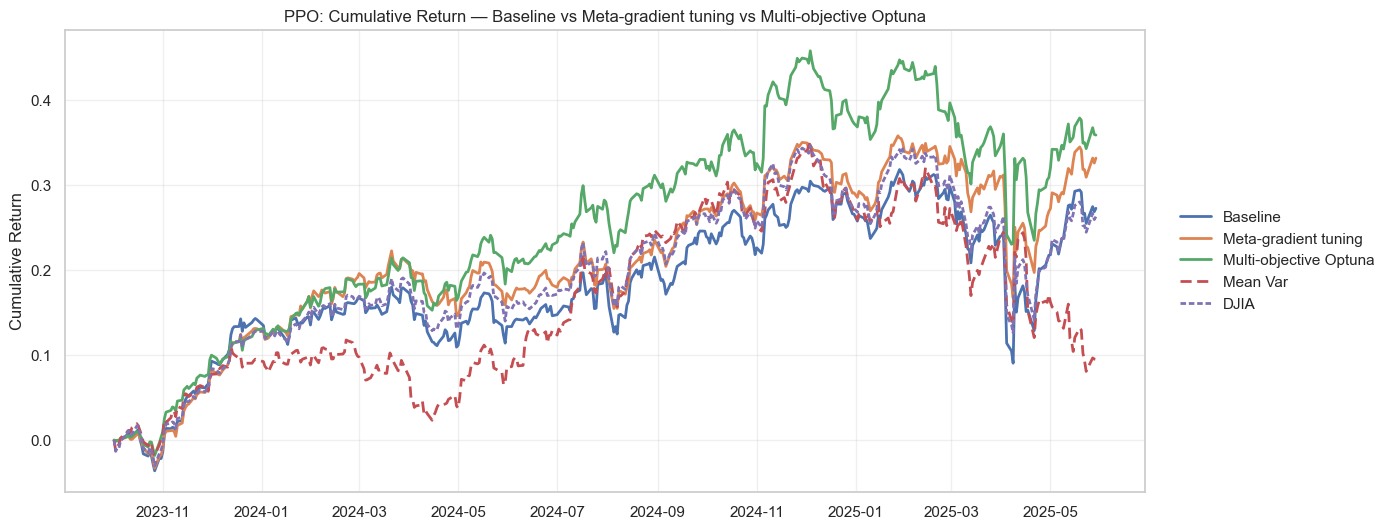

,Algorithm,Method,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,PPO,Baseline,15.69,17.65,0.95,0.92,-18.6%
1,PPO,DJIA,15.21,14.92,1.02,0.93,-16.4%
2,PPO,Meta-gradient tuning,18.96,15.40,1.20,1.27,-15.8%
3,PPO,Multi-objective Optuna,20.27,16.32,1.19,1.14,-17.8%



================  DDPG: Baseline vs Meta-gradient tuning vs Multi-objective Optuna  ================

hit end!
hit end!
hit end!
hit end!
hit end!
hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.36GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.36GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.36GB
  warnings.warn(


hit end!


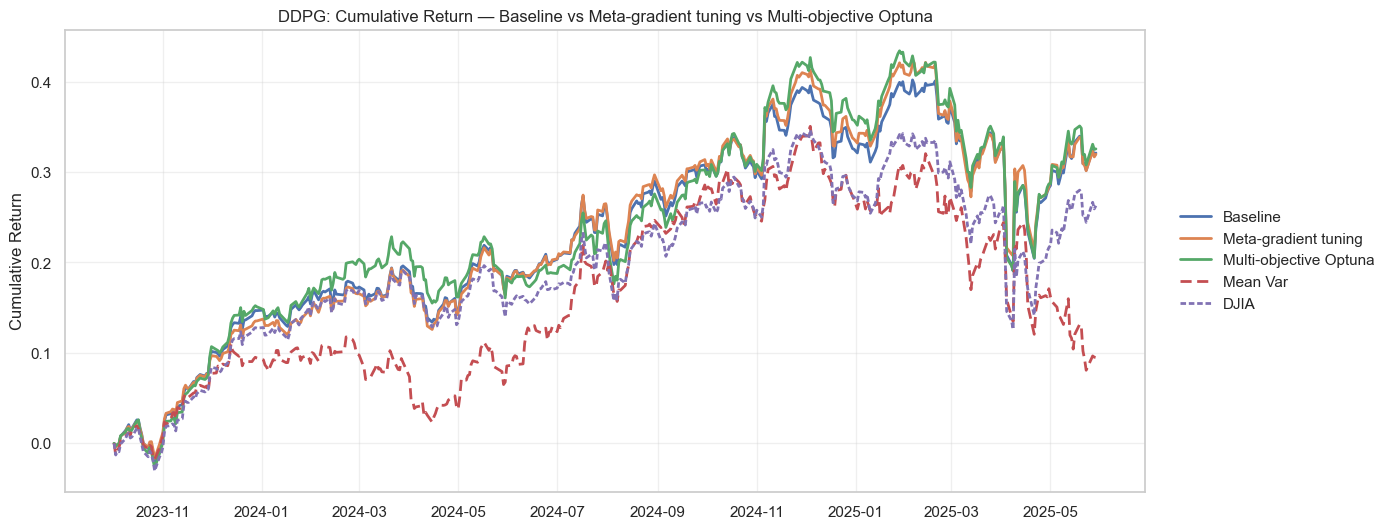

,Algorithm,Method,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,DDPG,Baseline,18.36,15.79,1.14,1.17,-16.1%
1,DDPG,DJIA,15.21,14.92,1.02,0.93,-16.4%
2,DDPG,Meta-gradient tuning,18.33,15.39,1.18,1.18,-15.8%
3,DDPG,Multi-objective Optuna,18.59,16.48,1.10,1.05,-17.6%



================  TD3: Baseline vs Meta-gradient tuning vs Multi-objective Optuna  ================



c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.30GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.25GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.22GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.23GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.22GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.20GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.20GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.21GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.20GB
  warnings.warn(


hit end!


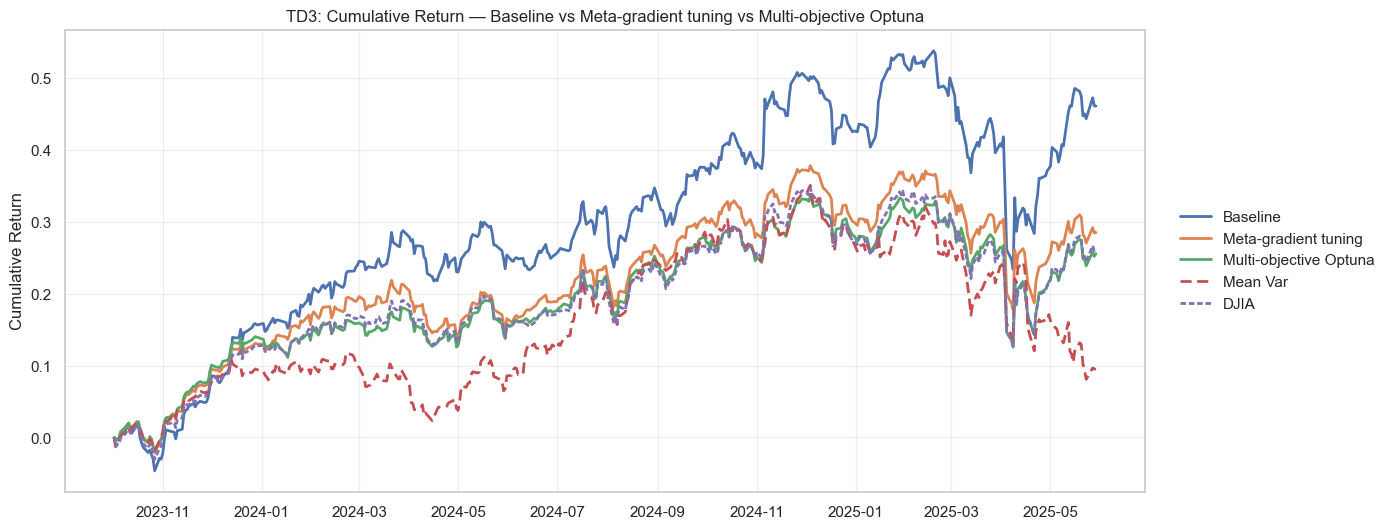

,Algorithm,Method,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,TD3,Baseline,25.82,17.89,1.38,1.32,-19.7%
1,TD3,DJIA,15.21,14.92,1.02,0.93,-16.4%
2,TD3,Meta-gradient tuning,16.41,14.56,1.12,1.12,-15.7%
3,TD3,Multi-objective Optuna,14.78,15.42,0.97,0.91,-16.5%



================  SAC: Baseline vs Meta-gradient tuning vs Multi-objective Optuna  ================

hit end!
hit end!
hit end!
hit end!
hit end!
hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.23GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.32GB
  warnings.warn(


hit end!


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.31GB
  warnings.warn(


hit end!


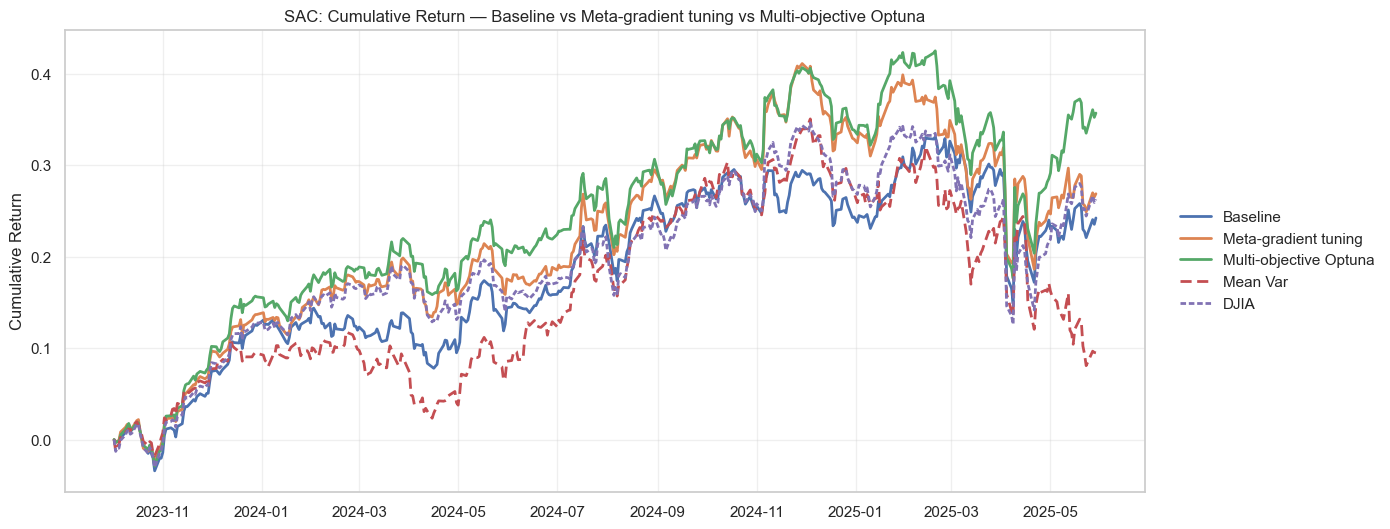

,Algorithm,Method,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,SAC,Baseline,14.04,16.41,0.87,0.90,-15.9%
1,SAC,DJIA,15.21,14.92,1.02,0.93,-16.4%
2,SAC,Meta-gradient tuning,15.51,15.65,0.99,0.94,-16.3%
3,SAC,Multi-objective Optuna,20.34,16.24,1.22,1.15,-17.7%


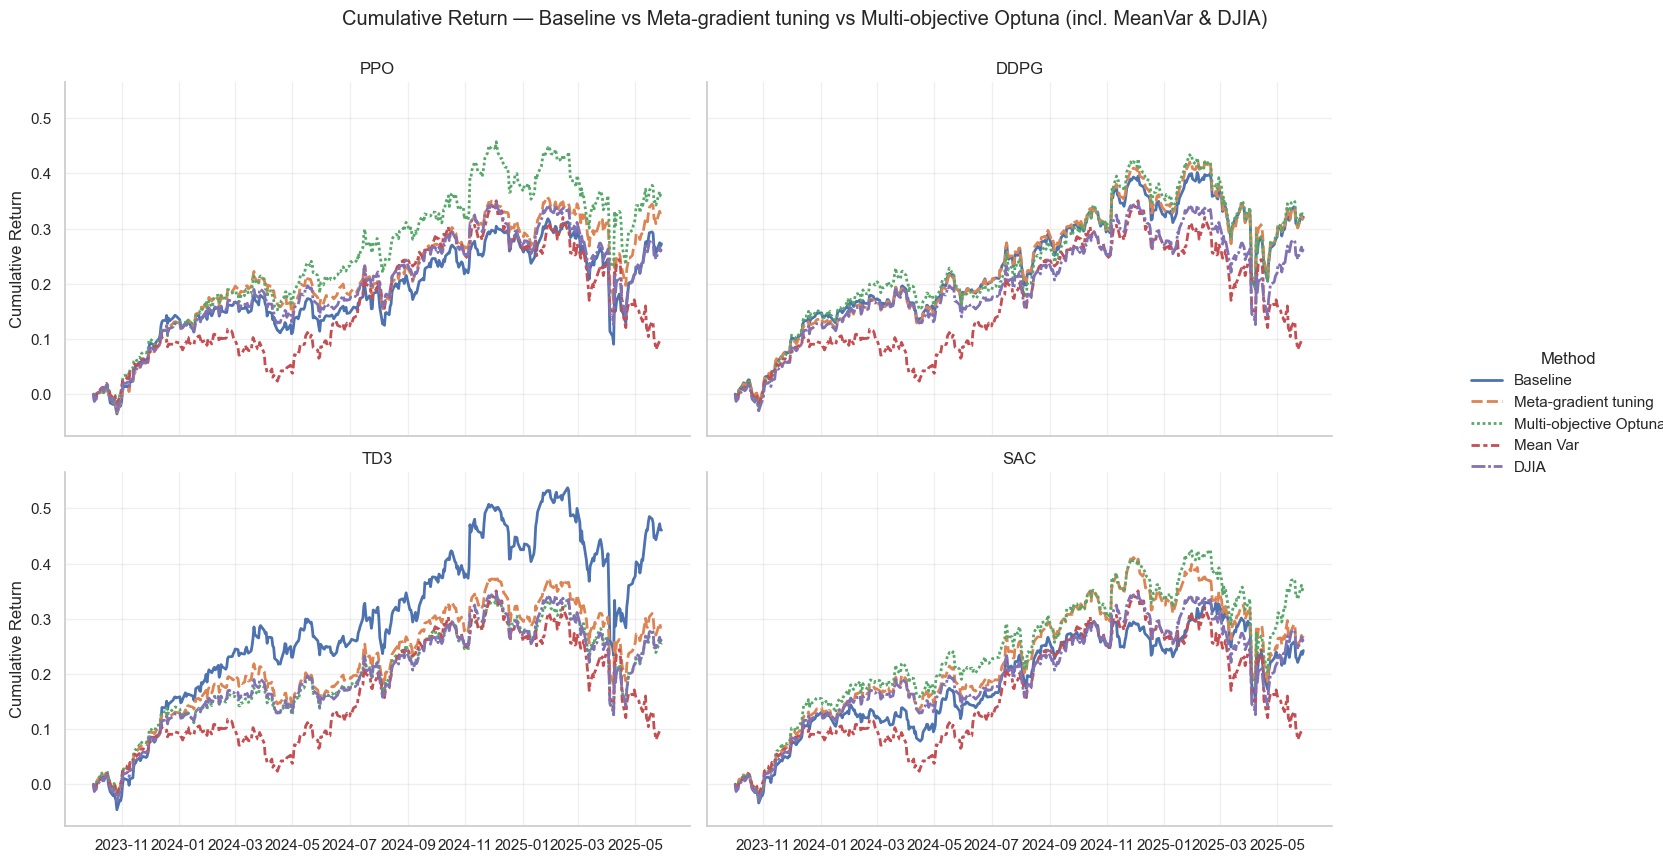

In [47]:
# CELL 4: Run evaluation — seaborn plots (per algo) + one big facet figure, incl. MeanVar & DJIA

import seaborn as sns

all_algo_tables = []
big_plot_rows = []     # collect per-algorithm curves to build one big figure later

sns.set_theme(style="whitegrid")

for algo in ALGO_LIST:
    print(f"\n================  {algo}: Baseline vs Meta-gradient tuning vs Multi-objective Optuna  ================\n")
    out_dir = os.path.join(TUNING_RESULTS_DIR, algo)
    os.makedirs(out_dir, exist_ok=True)

    # 1) Gather runs per method using per-algo folders
    runs_by_method = {}   # method -> list of curves
    for method, by_algo_map in METHOD_PATHS.items():
        folder = by_algo_map.get(algo)
        if not folder or not isinstance(folder, (str, os.PathLike)):
            print(f"[{method}] no folder configured for {algo} — skipping")
            runs_by_method[method] = []
            continue

        method_runs = []
        for i in range(LOOP_COUNT):
            mp = find_model_file(folder, algo, i)
            if not mp:
                print(f"[{method}/{algo}] missing model for seed {i} in {folder}")
                continue
            vals = evaluate_one_model(mp, trade_df=trade)
            if vals is None or len(vals) < 2 or not np.isfinite(vals).all():
                print(f"[{method}/{algo}] bad curve at seed {i}")
                continue
            method_runs.append(vals)

        if not method_runs:
            print(f"[warn] No runs for {method}/{algo}")
        runs_by_method[method] = method_runs

    # 2) Average across runs -> one curve per method, aligned by min length L
    L = None
    for runs in runs_by_method.values():
        if runs:
            Li = min(len(x) for x in runs)
            L = Li if (L is None) else min(L, Li)
    if L is None:
        print(f"[skip] {algo}: no data across methods")
        continue

    series_for_plot = {}
    for method, runs in runs_by_method.items():
        if not runs:
            continue
        avg = np.mean([np.asarray(x[:L], dtype=float) for x in runs], axis=0)
        series_for_plot[method] = avg  # numpy array length L

    # 2b) Inject financial baselines (MeanVar & DJIA)
    # Build baseline series with the same date index; align length with methods
    baseline_series = {}
    trade_dates_full = pd.to_datetime(trade["date"].drop_duplicates().values)

    if 'MVO_result' in globals() and isinstance(MVO_result, pd.DataFrame) and "Mean Var" in MVO_result.columns:
        mv_vals = MVO_result["Mean Var"].to_numpy(dtype="float64", copy=False)
        n = min(len(mv_vals), len(trade_dates_full))
        baseline_series["Mean Var"] = pd.Series(mv_vals[:n], index=trade_dates_full[:n], name="Mean Var")

# DJIA from dji["close"]
    if 'dji' in globals() and isinstance(dji, pd.DataFrame) and "close" in dji.columns:
        dj_vals = dji["close"].to_numpy(dtype="float64", copy=False)
        n = min(len(dj_vals), len(trade_dates_full))
        baseline_series["DJIA"] = pd.Series(dj_vals[:n], index=trade_dates_full[:n], name="DJIA")

    # If baselines exist, shrink L to also fit them
    if baseline_series:
        L_all = min([L] + [len(s) for s in baseline_series.values()])
        if L_all < L:
            L = L_all
            # re-trim method series to new L
            for k in list(series_for_plot.keys()):
                series_for_plot[k] = np.asarray(series_for_plot[k][:L], dtype=float)

    # Add baselines to series_for_plot
    for label, s in baseline_series.items():
        series_for_plot[label] = np.asarray(s.values[:L], dtype=float)

    # 3) Build cumulative return DF and seaborn plot (per-algorithm)
    dates = pd.to_datetime(trade["date"].drop_duplicates().values)[:L]
    cumret_df = pd.DataFrame({"date": dates})
    for label, series in series_for_plot.items():
        v = np.asarray(series[:L], dtype=float)
        cumret_df[label] = (v / v[0]) - 1.0

    # melt for seaborn and tag with Algorithm
    plot_df = cumret_df.melt(id_vars="date", var_name="Method", value_name="Cumulative Return")
    plot_df["Algorithm"] = algo
    big_plot_rows.append(plot_df)

    # ---- per-algorithm seaborn figure ----
    fig, ax = plt.subplots(figsize=(16, 6), constrained_layout=False)

    # Build a complete dashes map for all methods
    method_levels = plot_df["Method"].astype(str).unique().tolist()
    dashes_map = {m: "" for m in method_levels}     # default solid
    if "Mean Var" in dashes_map: dashes_map["Mean Var"] = (4, 2)   # dashed
    if "DJIA" in dashes_map:     dashes_map["DJIA"]     = (2, 1)   # dotted

    sns.lineplot(
        data=plot_df,
        x="date", y="Cumulative Return",
        hue="Method",
        style="Method",
        style_order=method_levels,   # ensure mapping lines up
        dashes=dashes_map,           # mapping covers ALL levels now
        linewidth=2,
        ax=ax
    )

    ax.set_title(f"{algo}: Cumulative Return — Baseline vs Meta-gradient tuning vs Multi-objective Optuna")
    ax.set_ylabel("Cumulative Return")
    ax.set_xlabel("")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.subplots_adjust(right=0.8)
    fig.savefig(
        os.path.join(out_dir, f"{algo}_cumret_{safe_name('Baseline_vs_Meta-gradient tuning_vs_Multi-objective Optuna')}.png"),
        dpi=200, bbox_inches="tight"
    )
    plt.show()


    # 4) Metrics table (mean of per-run metrics per method) + baselines
    rows = []
    # methods (averaged across seeds)
    for method, runs in runs_by_method.items():
        if not runs:
            continue
        metric_bags = []
        for vals in runs:
            arr = np.asarray(vals[:L], dtype=float)
            metric_bags.append(compute_financial_metrics(arr))
        if not metric_bags:
            continue
        dfm = pd.DataFrame(metric_bags)
        dfm["_dd_num"] = dfm["Max Drawdown"].str.rstrip("%").astype(float)
        rows.append({
            "Algorithm": algo,
            "Method": method,
            "Annual Return": round(dfm["Annual Return"].mean(), 2),
            "Annual Volatility": round(dfm["Annual Volatility"].mean(), 2),
            "Sharpe Ratio": round(dfm["Sharpe Ratio"].mean(), 2),
            "Calmar Ratio": round(dfm["Calmar Ratio"].replace(np.inf, np.nan).mean(skipna=True), 2),
            "Max Drawdown": f"{round(dfm['_dd_num'].mean(), 1)}%",
        })
    # baselines (single curve each)
    for label in ["MeanVar", "DJIA"]:
        if label in series_for_plot:
            arr = np.asarray(series_for_plot[label][:L], dtype=float)
            m = compute_financial_metrics(arr)
            rows.append({
                "Algorithm": algo,
                "Method": label,
                "Annual Return": m["Annual Return"],
                "Annual Volatility": m["Annual Volatility"],
                "Sharpe Ratio": m["Sharpe Ratio"],
                "Calmar Ratio": m["Calmar Ratio"],
                "Max Drawdown": m["Max Drawdown"],
            })

    algo_table = pd.DataFrame(rows, columns=[
        "Algorithm","Method","Annual Return","Annual Volatility","Sharpe Ratio","Calmar Ratio","Max Drawdown"
    ]).sort_values(["Algorithm","Method"]).reset_index(drop=True)

    all_algo_tables.append(algo_table)
    algo_table.to_csv(
        os.path.join(out_dir, f"{algo}_metrics_{safe_name('Baseline_vs_Meta-gradient tuning_vs_Multi-objective Optuna')}.csv"),
        index=False
    )
    display(algo_table)

# ===== One big figure at the end (facet per Algorithm) =====
if big_plot_rows:
    big_plot_df = pd.concat(big_plot_rows, ignore_index=True)

    g = sns.relplot(
        data=big_plot_df,
        x="date", y="Cumulative Return",
        hue="Method", style="Method", kind="line",
        col="Algorithm", col_wrap=2,   # adjust columns if you have more algos
        height=4.5, aspect=1.6,
        linewidth=2,
        facet_kws=dict(sharey=True, sharex=True)
    )
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.set_xlabel("")
        ax.set_ylabel("Cumulative Return")
        ax.grid(True, alpha=0.3)

    if g._legend is not None:
        g._legend.set_title("Method")
        g._legend.set_bbox_to_anchor((1.02, 0.5))
        g._legend.set_frame_on(False)

    g.fig.subplots_adjust(top=0.9, right=0.82)
    g.fig.suptitle("Cumulative Return — Baseline vs Meta-gradient tuning vs Multi-objective Optuna (incl. MeanVar & DJIA)")

    big_path = os.path.join(TUNING_RESULTS_DIR, "ALL_algos_cumret_facet.png")
    g.savefig(big_path, dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("No data collected for the combined figure — check METHOD_PATHS and seeds.")


In [49]:
# CELL 5: Combined table (all algorithms) — de-duplicate Mean Var & DJIA

BASELINE_METHODS = ["Mean Var", "DJIA"]

if all_algo_tables:
    big_df = pd.concat(all_algo_tables, ignore_index=True)

    # Remove per-algorithm baseline rows (they repeat)
    non_baseline = big_df[~big_df["Method"].isin(BASELINE_METHODS)].copy()

    # Compute Mean Var & DJIA once from global sources, aligned to trade dates
    baseline_rows = []
    dates = pd.to_datetime(trade["date"].drop_duplicates().values)

    # Mean Var from MVO_result["Mean Var"]
    if "MVO_result" in globals() and isinstance(MVO_result, pd.DataFrame) and "Mean Var" in MVO_result.columns:
        mv_vals = MVO_result["Mean Var"].to_numpy(dtype="float64", copy=False)[: len(dates)]
        if len(mv_vals) > 1 and np.isfinite(mv_vals).all():
            m = compute_financial_metrics(mv_vals)
            baseline_rows.append({
                "Algorithm": "(financial baseline)",
                "Method": "Mean Var",
                "Annual Return": m["Annual Return"],
                "Annual Volatility": m["Annual Volatility"],
                "Sharpe Ratio": m["Sharpe Ratio"],
                "Calmar Ratio": m["Calmar Ratio"],
                "Max Drawdown": m["Max Drawdown"],
            })

    # DJIA from dji["close"]
    if "dji" in globals() and isinstance(dji, pd.DataFrame) and "close" in dji.columns:
        dj_vals = dji["close"].to_numpy(dtype="float64", copy=False)[: len(dates)]
        if len(dj_vals) > 1 and np.isfinite(dj_vals).all():
            m = compute_financial_metrics(dj_vals)
            baseline_rows.append({
                "Algorithm": "(financial baseline)",
                "Method": "DJIA",
                "Annual Return": m["Annual Return"],
                "Annual Volatility": m["Annual Volatility"],
                "Sharpe Ratio": m["Sharpe Ratio"],
                "Calmar Ratio": m["Calmar Ratio"],
                "Max Drawdown": m["Max Drawdown"],
            })

    baselines_once = pd.DataFrame(
        baseline_rows,
        columns=["Algorithm","Method","Annual Return","Annual Volatility","Sharpe Ratio","Calmar Ratio","Max Drawdown"]
    )

    # Combine back and save
    final_df = pd.concat([non_baseline, baselines_once], ignore_index=True)
    final_df = final_df.sort_values(["Algorithm","Method"]).reset_index(drop=True)
    final_df.to_csv(
        os.path.join(
            TUNING_RESULTS_DIR,
            f"all_algos_metrics_{safe_name('Baseline_vs_Meta-gradient tuning_vs_Multi-objective Optuna')}.csv"
        ),
        index=False
    )
    display(final_df)
else:
    print("No tables aggregated — check paths and seeds.")


,Algorithm,Method,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,(financial baseline),DJIA,15.21,14.92,1.02,0.93,-16.4%
1,(financial baseline),Mean Var,5.65,15.79,0.43,0.28,-20.0%
2,DDPG,Baseline,18.36,15.79,1.14,1.17,-16.1%
3,DDPG,Meta-gradient tuning,18.33,15.39,1.18,1.18,-15.8%
4,DDPG,Multi-objective Optuna,18.59,16.48,1.10,1.05,-17.6%
5,PPO,Baseline,15.69,17.65,0.95,0.92,-18.6%
6,PPO,Meta-gradient tuning,18.96,15.40,1.20,1.27,-15.8%
7,PPO,Multi-objective Optuna,20.27,16.32,1.19,1.14,-17.8%
8,SAC,Baseline,14.04,16.41,0.87,0.90,-15.9%
9,SAC,Meta-gradient tuning,15.51,15.65,0.99,0.94,-16.3%
